In [22]:
!pip install umap-learn --quiet
!pip install trimap --quiet
!pip install pacmap --quiet

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_auc_score
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

In [24]:
data = pd.read_csv("echocardiogram.csv").dropna()

# with pd.option_context("display.max_rows", 1000):
#     display(data)

data

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score,wallmotion-index,mult,name,group,aliveat1
0,11.00,0.0,71.0,0.0,0.260,9.000,4.600,14.00,1.00,1.000,name,1,0.0
1,19.00,0.0,72.0,0.0,0.380,6.000,4.100,14.00,1.70,0.588,name,1,0.0
2,16.00,0.0,55.0,0.0,0.260,4.000,3.420,14.00,1.00,1.000,name,1,0.0
3,57.00,0.0,60.0,0.0,0.253,12.062,4.603,16.00,1.45,0.788,name,1,0.0
4,19.00,1.0,57.0,0.0,0.160,22.000,5.750,18.00,2.25,0.571,name,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,1.25,1.0,63.0,0.0,0.300,6.900,3.520,18.16,1.51,0.857,name,2,1.0
106,24.00,0.0,59.0,0.0,0.170,14.300,5.490,13.50,1.50,0.643,name,2,0.0
107,25.00,0.0,57.0,0.0,0.228,9.700,4.290,11.00,1.00,0.786,name,2,0.0
109,0.75,1.0,78.0,0.0,0.230,40.000,6.230,14.00,1.40,0.714,name,2,1.0


In [25]:
# target_columns = ['survival', 'alive', 'aliveat1']
target_columns = ['aliveat1']
feature_columns = [
    # 'survival', 'alive' , 'aliveat1',
    'age', 'pericardialeffusion', 'fractionalshortening',
    'epss', 'lvdd', 'wallmotion-score', 'wallmotion-index', 'mult'
]

X = data[feature_columns]
y = data[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train = y_train.values.ravel()
y_test = np.array(y_test)

# Балансировка классов
methods = {
    'Original': (X_train, y_train),
    'SMOTE': SMOTE(random_state=42).fit_resample(X_train, y_train),
    'Borderline-SMOTE': BorderlineSMOTE(kind='borderline-1', random_state=42).fit_resample(X_train, y_train),
    'Borderline-SMOTE2': BorderlineSMOTE(kind='borderline-2', random_state=42).fit_resample(X_train, y_train),
}

# Методы снижения размерности
reducers = {
    'PCA': PCA(n_components=2),
    't-SNE': TSNE(n_components=2, random_state=42),
    'UMAP': umap.UMAP(n_components=2),
    'TriMAP': trimap.TRIMAP(n_inliers=12, n_outliers=4, n_random=20),
    'PaCMAP': pacmap.PaCMAP(n_neighbors=10)
}

# Классификаторы
classifiers = {
        'SVM': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(random_state=42)
}

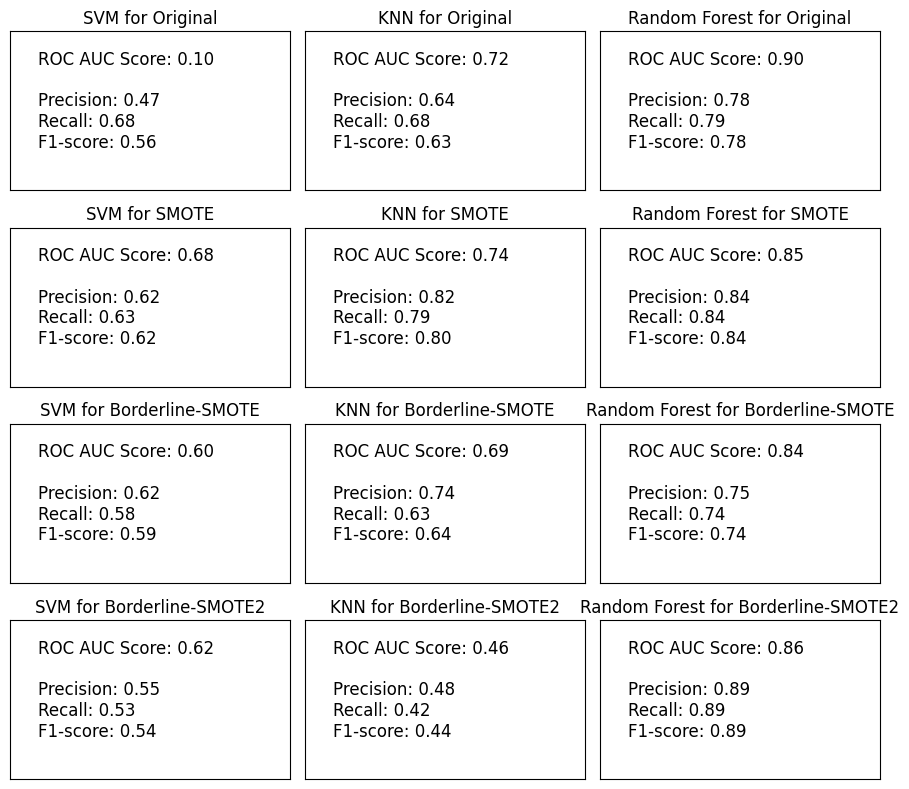

In [26]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    results = {}
    for clf_name, clf in classifiers.items():
        pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', clf)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        auc_score = roc_auc_score(y_test, y_proba)
        results[clf_name] = {
            'classification_report': report,
            'roc_auc_score': auc_score
        }
    return results


def plot_results_grid(results):
    method_names = list(results.keys())
    classifier_names = list(results[method_names[0]].keys())
    n_rows = len(method_names)
    n_cols = len(classifier_names)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2 * n_rows))

    for row_idx, method_name in enumerate(method_names):
        for col_idx, clf_name in enumerate(classifier_names):
            ax = axes[row_idx, col_idx]
            result = results[method_name][clf_name]
            report = result['classification_report']
            auc_score = result['roc_auc_score']

            report_str = f"ROC AUC Score: {auc_score:.2f}\n\n"
            report_str += f"Precision: {report['weighted avg']['precision']:.2f}\n"
            report_str += f"Recall: {report['weighted avg']['recall']:.2f}\n"
            report_str += f"F1-score: {report['weighted avg']['f1-score']:.2f}\n"
            ax.text(0.1, 0.5, report_str, fontsize=12, va='center', ha='left')

            ax.set_title(f'{clf_name} for {method_name}')
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])

    plt.tight_layout()
    plt.show()

results = {}
for method_name, (X_res, y_res) in methods.items():
    results[method_name] = train_and_evaluate(X_res, y_res, X_test, y_test)

plot_results_grid(results)

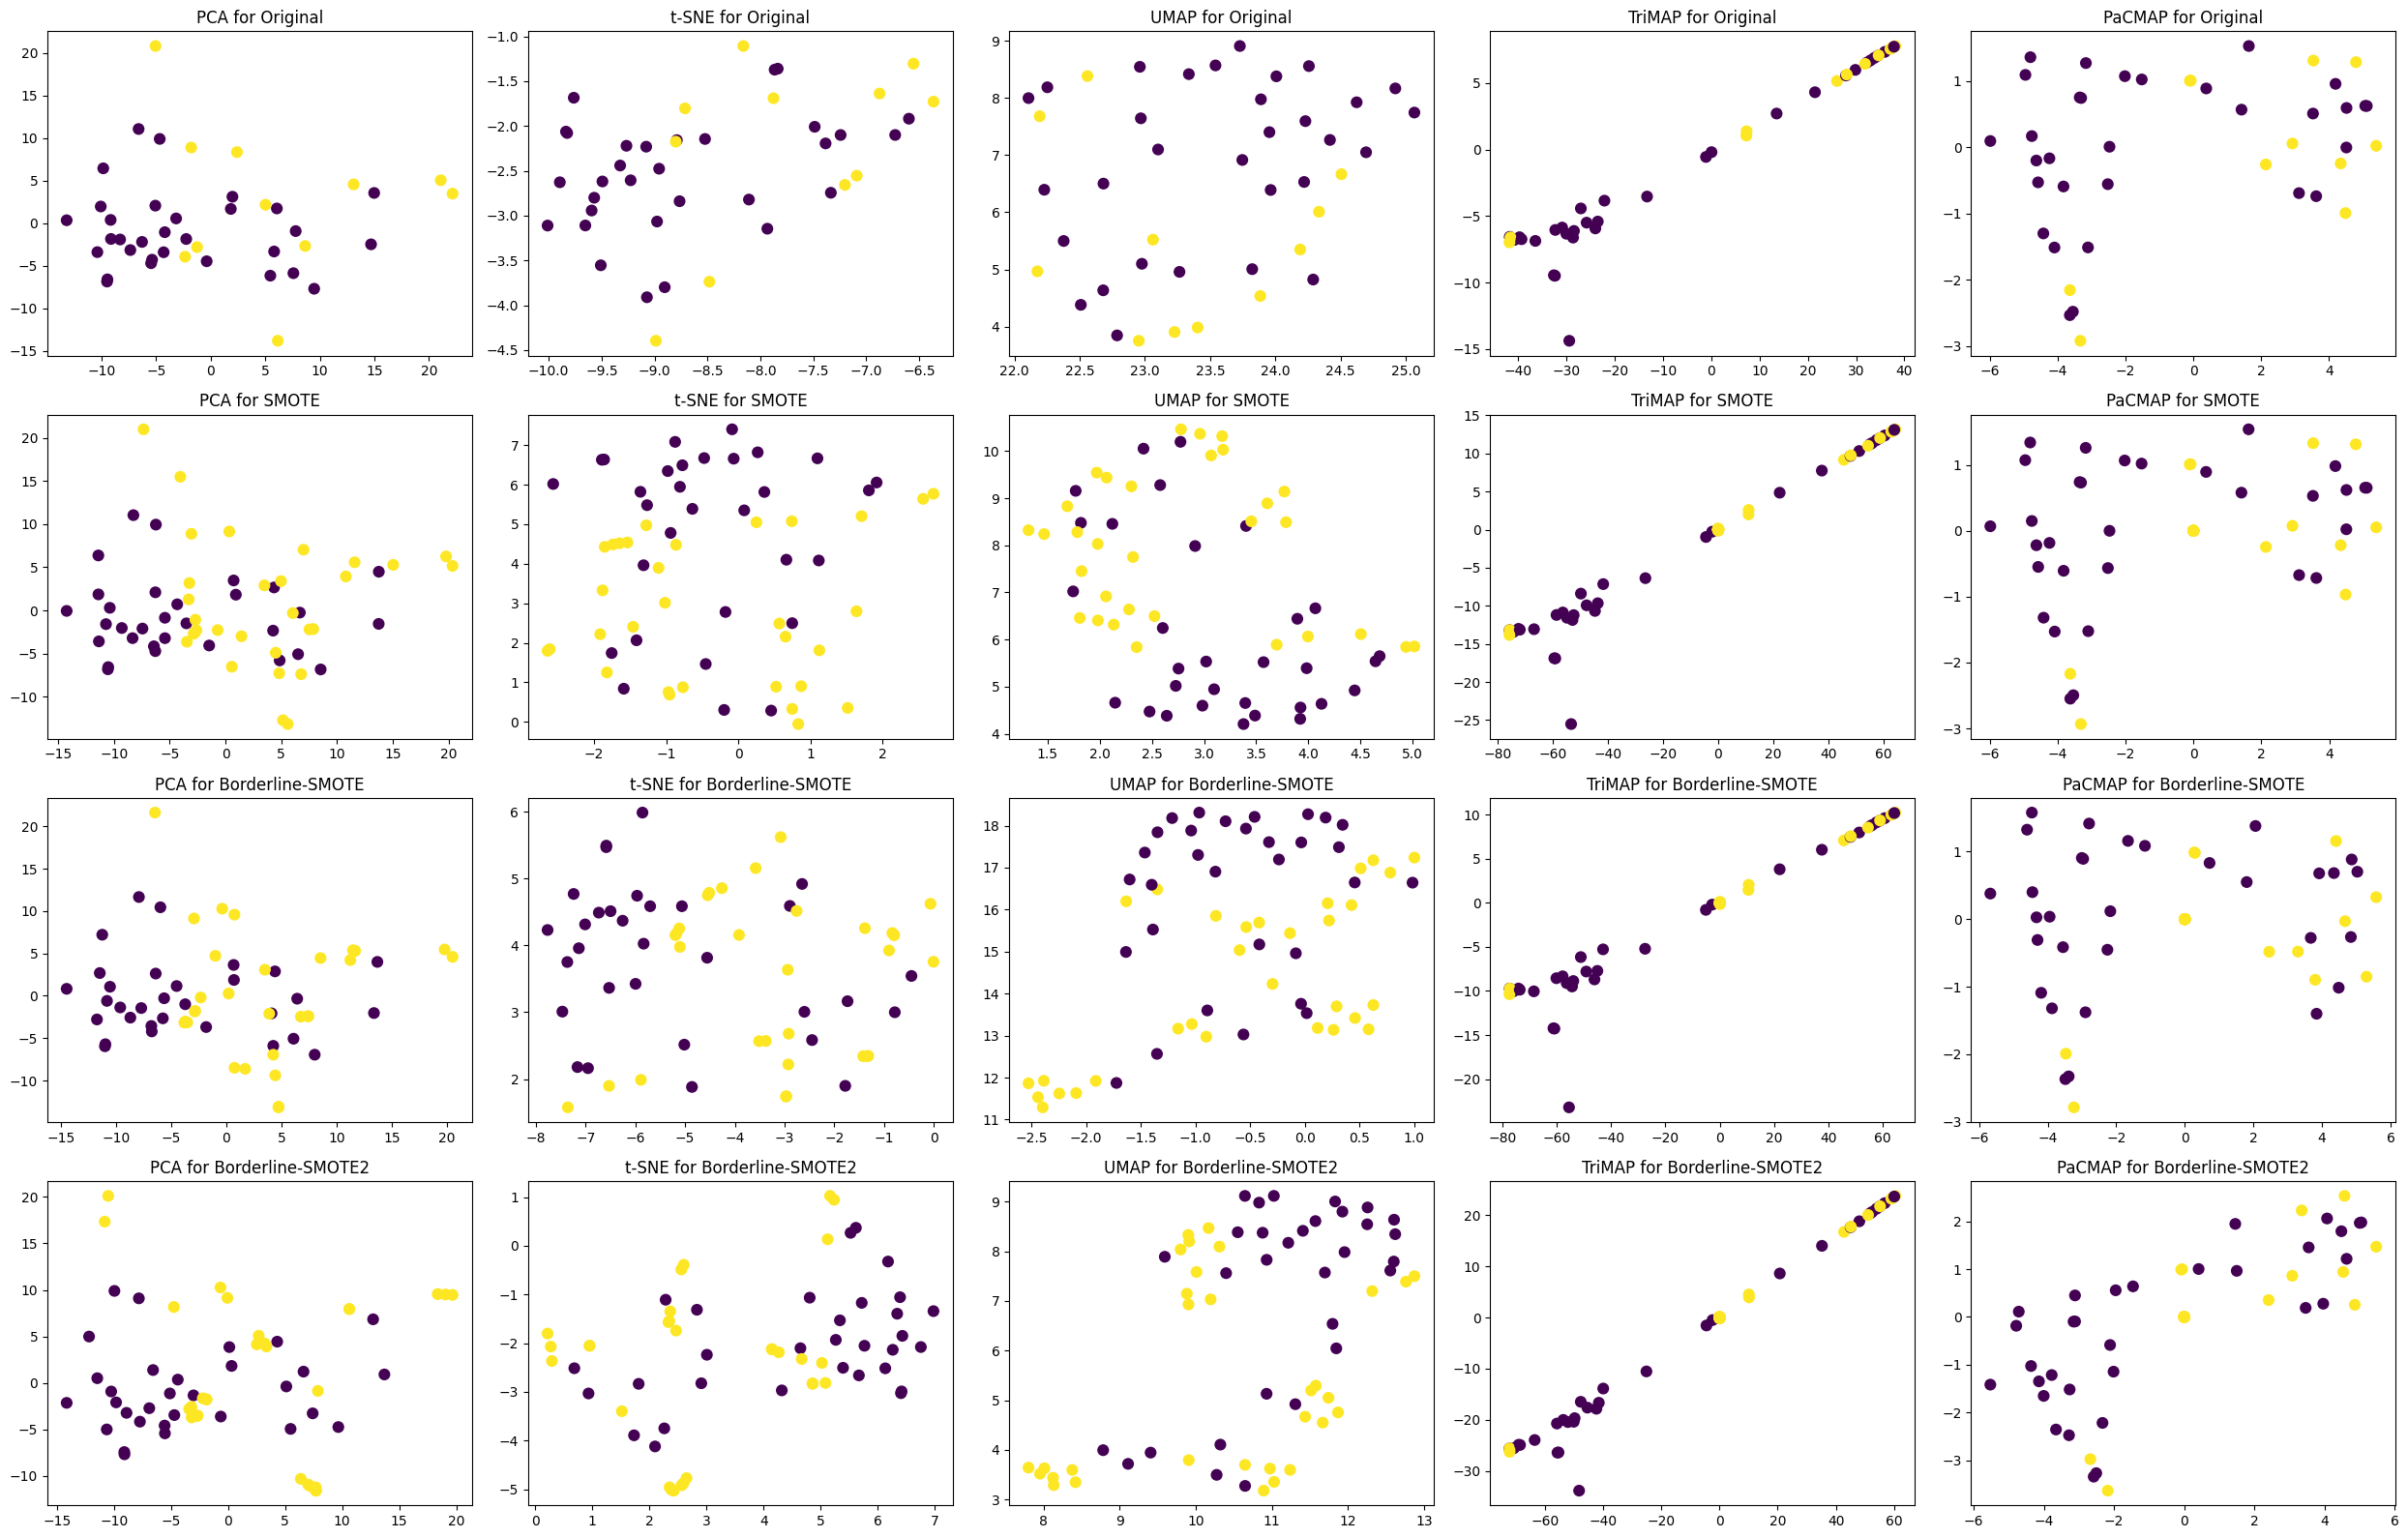

In [27]:
# Визуализация данных с помощью t-SNE, UMAP, TriMAP и PaCMAP
def visualize(X, y, method_name, dim_reducer, reducer_name, ax):
    X = np.array(X)
    X_reduced = dim_reducer.fit_transform(X)
    scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', s=60)
    ax.set_title(f'{reducer_name} for {method_name}')
    return scatter


n_rows = len(methods)
n_cols = len(reducers)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

for row_idx, (method_name, (X_res, y_res)) in enumerate(methods.items()):
    for col_idx, (reducer_name, reducer) in enumerate(reducers.items()):
        ax = axes[row_idx, col_idx]
        scatter = visualize(X_res, y_res, method_name, reducer, reducer_name, ax)

plt.tight_layout()
plt.show()